# Classification, and scaling up our networks

In this guide we introduce neural networks for classification, and using Keras, we will begin to try solving problems and datasets that are much bigger than the toy datasets like Iris we have used so far. In this notebook, we will define classification and introduce several innovations we have to make in order to do it correctly, and we will also use two large standard datasets which have been used by machine learning scientists for many years: MNIST and CIFAR-10.

### Classification

Classification is a task in which all data points are assigned some discrete category. For regression of a single output variable, we have a single output neuron, as we have seen in previous notebooks. For doing multi-class classification, we instead have an output neuron for each of the possible classes, and say that the predicted output is the one corresponding to the neuron which has the highest output value. For example, given the task of classifying images of handwritten digits (which we will introduce later), we might build a neural network like the following, having 10 output neurons for each of the 10 digits.

![classification](https://ml4a.github.io/images/figures/mnist_2layers.png)

Before trying out neural networks for classification, we have to introduce two new concepts: the softmax function, and cross-entropy loss.

### Softmax activation

So far, we have learned about one activation function, that of the sigmoid function. We saw that we use this typically in all the layers of a neural network except the output layer, which is usually left linear (without an activation function) for the task of regression. But in classification, it is very typical to output the final layer outputs through the [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function). Given a final layer output vector $z$, the softmax function is defined as the following:

$$\sigma (\mathbf {z} )_{i}={\frac {e^{z_{i}}}{\sum _{i}e^{z_{i}}}}$$

Where the denominator $\sum _{i=1}e^{z_{i}}$ is the sum over all the classes. Softmax squashes the output $z$, which is unbounded, to values between 0 and 1, and dividing it by the sum over all the classes means that the output sums to 1. This means we can interpret the output as class probabilities. 

We will use the softmax activation for the classification output layer from here on out. A short example follows:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def softmax(Z):
    Z = [np.exp(z) for z in Z]
    S = np.sum(Z)
    Z /= S
    return Z

Z = [0.0, 2.3, 1.0, 0, 5.3, 0.0]
y = softmax(Z)

print("Z =", Z)
print("y =", y)

Z = [0.0, 2.3, 1.0, 0, 5.3, 0.0]
y = [0.004629   0.04617051 0.01258293 0.004629   0.92735955 0.004629  ]


We were given a length-6 vector $Z$ containing the values $[0.0, 2.3, 1.0, 0, 8.3, 0.0]$. We ran it through the softmax function, and we plot it below:

<BarContainer object of 6 artists>

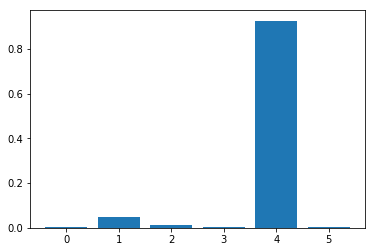

In [2]:
plt.bar(range(len(y)), y)

Notice that because of the exponential nature of $e$, the 5th value in $Z$, 5.3, has an over 90% probability. Softmax tends to exaggerate the differences in the original output.

### Categorical cross-entropy loss

We introduced loss functions in the last guide, and we used the simple mean-squared error (MSE) function to evaluate the performance of our network. While MSE works nicely for regression, and can work for classification as well, it is generally not preferred for classification, because class variables are not naturally continuous and therefore, the MSE error, being a continuous value is not exactly relevant or "natural." Instead, what scientists generally prefer for classification is [categorical cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy). 

A discussion or derivation of cross-entropy loss is beyond the scope of this class but a good introduction to it can be [found here](https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/). A discussion of what makes it superior to MSE for classification can be found [here](https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/).  We will just focus on its properties instead.

Letting $y_i$ denote the ground truth value of class $i$, and $\hat{y}_i$ be our prediction of class $i$, the cross-entropy loss is defined as:

$$ H(y, \hat{y}) = -\sum_{i} y_i \log \hat{y}_i $$

If the number of classes is 2, we can expand this:

$$ H(y, \hat{y}) = -{(y\log(\hat{y}) + (1 - y)\log(1 - \hat{y}))}\ $$

Notice that as our probability for the predicting the correct class approaches 1, the cross-entropy approaches 0. For example, if $y=1$, then as $\hat{y}\rightarrow 1$, $H(y, \hat{y}) \rightarrow 0$. If our probability for the correct class approaches 0 (the exact wrong prediction), e.g. if $y=1$ and $\hat{y} \rightarrow 0$, then $H(y, \hat{y}) \rightarrow \infty$.

This is true in the more general $M$-class cross-entropy loss as well, $ H(y, \hat{y}) = -\sum_{i} y_i \log \hat{y}_i $, where if our prediction is very close to the true label, then the entropy loss is close to 0, whereas the more dissimilar the prediction is to the true class, the higher it is.

Minor note: in practice, a very small $\epsilon$ is added to the log, e.g. $\log(\hat{y}+\epsilon)$ to avoid $\log 0$ which is undefined.


### MNIST: the "hello world" of classification

In the last guide, we introduced [Keras](https://www.keras.io). We will now use it to solve a classification problem, that of MNIST. First, let's import Keras and the other python libraries we will need.

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten

from keras.layers import Activation

Using TensorFlow backend.


We are also now going to scale up our setup by using a much more complicated dataset than Iris, that of the [MNIST](http://yann.lecun.com/exdb/mnist/), a dataset of 70,000 28x28 pixel grayscale images of handwritten numbers, manually classified into the 10 digits, and split into a canonical training set and test set. We can load MNIST with the following code:

In [4]:
from keras.datasets import mnist
 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

Let's see what the data is packaged like:

In [5]:
print('%d train samples, %d test samples'% (x_train.shape[0], x_test.shape[0]))
print("training data shape: ", x_train.shape, y_train.shape)
print("test data shape: ", x_test.shape, y_test.shape)

60000 train samples, 10000 test samples
training data shape:  (60000, 28, 28) (60000,)
test data shape:  (10000, 28, 28) (10000,)


Let's look at some samples of the images.

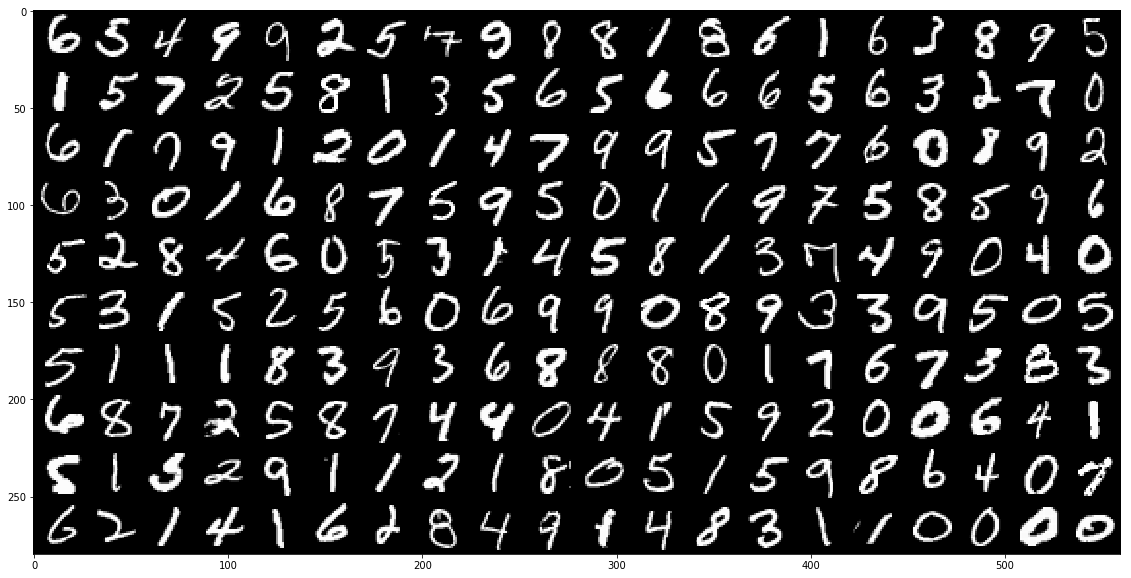

In [6]:
samples = np.concatenate([np.concatenate([x_train[i] for i in [int(random.random() * len(x_train)) for i in range(20)]], axis=1) for i in range(10)], axis=0)
plt.figure(figsize=(20,10))
plt.imshow(samples, cmap='gray')

As before, we need to pre-process the data for Keras.  To do so, we will reshape the image arrays from $n$x28x28 to $n$x784, so each row of the data is the full "unrolled" list of pixels, and we will ensure they are float32 for precision. We then normalize the pixel values (which are naturally between 0 and 255) so that they are all between 0 and 1 instead.

In [7]:
# reshape to input vectors
(x_train, y_train), (x_test, y_test) = mnist.load_data()

flatten_size = x_train.shape[1] * x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], flatten_size)
x_test = x_test.reshape(x_test.shape[0], flatten_size)

# make float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize to (0-1)
x_train /= 255
x_test /= 255


In classification, we will eventually structure our neural networks so that they have $n$ output neurons, 1 for each class. The idea is whichever output neuron has the highest value at the end is the predicted class. For this, we must structure our labels as "one-hot" vectors, which are vectors of length $n$ where $n$ is the number of classes, and the elements are all 0 except for the correct label, which is 1. For example, an image of the number 3 would be:

$[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]$

And for the number 7 it would be:

$[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]$

Notice we are zero-indexed again, so the first element is for the digit 0.

In [8]:
print("first sample of y_train before one-hot vectorization", y_train[0])


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("first sample of y_train after one-hot vectorization", y_train[0])
print(y_test.shape)

first sample of y_train before one-hot vectorization 5
first sample of y_train after one-hot vectorization [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(10000, 10)


Now let's make a neural network for MNIST. We'll give it two layers of 100 neurons each, with sigmoid activations. Then we will make the output layer go through a softmax activation, the standard for classification.

In [9]:
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_dim=784))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

Thus, the network has 784 * 100 = 78,400 weights in the first layer, 100 * 100 = 10,000 weights in the second layer, and 100 * 10 = 1,000 weights in the output layer, plus 100 + 100 + 10 = 210 biases, giving us a total of 78,400 + 10,000 + 1,000 + 210 = 89,610 parameters. We can see this in the summary.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


We will compile our model to optimize for the categorical cross-entropy loss as described earlier, and we will use SGD as our optimizer again. We will also include the optional argument `metrics` to keep track of the accuracy during training, in addition to just the loss. The accuracy is the % of samples classified correctly.

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

We now train our network for 20 epochs and use a batch size of 100. We will talk in more detail later on how to choose these hyper-parameters. We use our validation set to evaluate our performance.

In [12]:
model.fit(x_train, y_train,
          batch_size=100,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 41us/step - loss: 2.2776 - acc: 0.1903 - val_loss: 2.2416 - val_acc: 0.3646
Epoch 2/20
60000/60000 [==============================] - 2s 38us/step - loss: 2.2056 - acc: 0.3511 - val_loss: 2.1609 - val_acc: 0.3649
Epoch 3/20
60000/60000 [==============================] - 2s 35us/step - loss: 2.1071 - acc: 0.4526 - val_loss: 2.0366 - val_acc: 0.5760
Epoch 4/20
60000/60000 [==============================] - 2s 34us/step - loss: 1.9539 - acc: 0.5481 - val_loss: 1.8485 - val_acc: 0.5676
Epoch 5/20
60000/60000 [==============================] - 3s 43us/step - loss: 1.7436 - acc: 0.6080 - val_loss: 1.6171 - val_acc: 0.6484
Epoch 6/20
60000/60000 [==============================] - 2s 39us/step - loss: 1.5128 - acc: 0.6690 - val_loss: 1.3890 - val_acc: 0.6856
Epoch 7/20
60000/60000 [==============================] - 2s 35us/step - loss: 1.3026 - acc: 0.7102 - val_loss: 1.1961 - val_acc

Evaluate the performance of the network.

In [14]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 28us/step
Test loss: 0.4691234758377075
Test accuracy: 0.8771


After 20 epochs, we have an accuracy of around 87%. Perhaps we can train it for a bit longer to get better performance?  Let's run fit again for another 20 epochs. Notice that as long as we don't recompile the model, we can keep running fit to try to improve the model. So we know that we don't necessarily have to decide ahead of time how long to train for, we can keep training as we see fit.

In [15]:
model.fit(x_train, y_train,
          batch_size=100,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.4770 - acc: 0.8735 - val_loss: 0.4541 - val_acc: 0.8794
Epoch 2/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.4629 - acc: 0.8765 - val_loss: 0.4411 - val_acc: 0.8816
Epoch 3/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.4503 - acc: 0.8794 - val_loss: 0.4288 - val_acc: 0.8852
Epoch 4/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.4388 - acc: 0.8820 - val_loss: 0.4183 - val_acc: 0.8863
Epoch 5/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.4285 - acc: 0.8847 - val_loss: 0.4091 - val_acc: 0.8884
Epoch 6/20
60000/60000 [==============================] - 2s 32us/step - loss: 0.4191 - acc: 0.8870 - val_loss: 0.4004 - val_acc: 0.8918
Epoch 7/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.4105 - acc: 0.8888 - val_loss: 0.3921 - val_acc

At this point our accuracy is at 90%. This seems not too bad! Random guesses would only get us 10% accuracy, so we must be doing something right. But 90% is not acceptable for MNIST. The current record for MNIST has 99.8% accuracy, which means our model makes 500 times as many errors as the best network.

So how can we improve it?  What if we make the network bigger? And train for longer?  Let's give it two layers of 256 neurons each, and then train for 60 epochs. 

In [16]:
model = Sequential()
model.add(Dense(256, activation='sigmoid', input_dim=784))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


The network now has 269,322 parameters, which is more than 3 times as many as the last network. Now train it.

In [17]:
model.fit(x_train, y_train,
          batch_size=100,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 63us/step - loss: 2.2680 - acc: 0.2197 - val_loss: 2.2263 - val_acc: 0.2796
Epoch 2/20
60000/60000 [==============================] - 4s 61us/step - loss: 2.1799 - acc: 0.4132 - val_loss: 2.1192 - val_acc: 0.4936
Epoch 3/20
60000/60000 [==============================] - 4s 64us/step - loss: 2.0467 - acc: 0.5410 - val_loss: 1.9481 - val_acc: 0.6079
Epoch 4/20
60000/60000 [==============================] - 4s 72us/step - loss: 1.8363 - acc: 0.6193 - val_loss: 1.6914 - val_acc: 0.6649
Epoch 5/20
60000/60000 [==============================] - 4s 68us/step - loss: 1.5597 - acc: 0.6734 - val_loss: 1.3971 - val_acc: 0.6971
Epoch 6/20
60000/60000 [==============================] - 4s 62us/step - loss: 1.2829 - acc: 0.7220 - val_loss: 1.1449 - val_acc: 0.7530
Epoch 7/20
60000/60000 [==============================] - 4s 62us/step - loss: 1.0672 - acc: 0.7604 - val_loss: 0.9636 - val_acc

Surprisingly, this new network only achieves 91.6% accuracy, which is only a bit better than the last one.

So maybe bigger is not better! The problem is that just making the network bigger has diminishing improvements for us. We are going to need to make more improvements to get good results. We will introduce some improvements in the next notebook.

Before we do that,let's try what we have so far with [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR-10 is a dataset which contains 60,000 32x32x3 RGB-color images of airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

The next cell will import that dataset, and tell us about it's shape.

In [18]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10

print('%d train samples, %d test samples'%(x_train.shape[0], x_test.shape[0]))
print("training data shape: ", x_train.shape, y_train.shape)
print("test data shape: ", x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 54s 0us/step
50000 train samples, 10000 test samples
training data shape:  (50000, 32, 32, 3) (50000, 1)
test data shape:  (10000, 32, 32, 3) (10000, 1)


Let's look at a random sample of images from CIFAR-10.

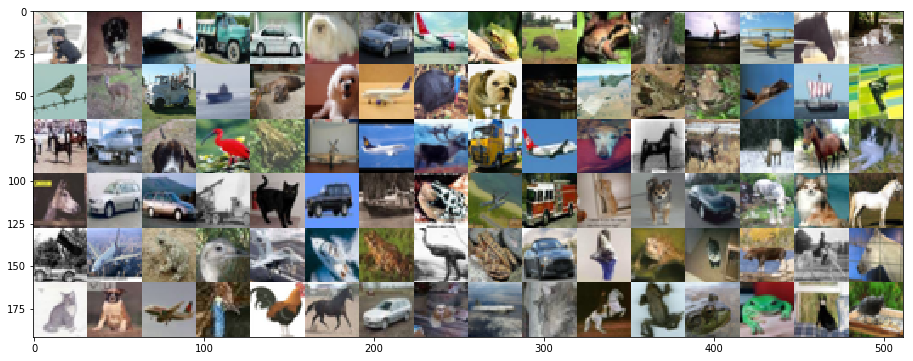

In [19]:
samples = np.concatenate([np.concatenate([x_train[i] for i in [int(random.random() * len(x_train)) for i in range(16)]], axis=1) for i in range(6)], axis=0)
plt.figure(figsize=(16,6))
plt.imshow(samples, cmap='gray')

As with MNIST, we need to pre-process the data by converting to float32 precision, reshaping so each row is a single input vector, and normalizing between 0 and 1. 

In [21]:
# reshape to input vectors
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)

# make float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize to (0-1)
x_train /= 255
x_test /= 255


Convert labels to one-hot vectors.

In [20]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Let's copy the last network we used for MNIST, and see how this architecture does for CIFAR-10. Note that the `input_dim` of the first layer is no longer 784 as it was for MNIST, but now it is 32x32x3=3072. This means we will have more parameters in this network than the MNIST network of the same architecture.

In [22]:
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_dim=3072))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________


This network now has 318,410 parameters, compared to 269,322 as we had in the equivalent MNIST network. Let's compile it to learn with SGD and the same categorical cross-entropy loss function.

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Now train for 60 epochs, same batch size.

In [ ]:
model.fit(x_train, y_train,
          batch_size=100,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 78us/step - loss: 2.2912 - acc: 0.1549 - val_loss: 2.2758 - val_acc: 0.1985
Epoch 2/20
50000/50000 [==============================] - 4s 73us/step - loss: 2.2626 - acc: 0.2174 - val_loss: 2.2479 - val_acc: 0.2435
Epoch 3/20
50000/50000 [==============================] - 3s 66us/step - loss: 2.2299 - acc: 0.2456 - val_loss: 2.2115 - val_acc: 0.2329
Epoch 4/20
50000/50000 [==============================] - 3s 67us/step - loss: 2.1876 - acc: 0.2526 - val_loss: 2.1660 - val_acc: 0.2386
Epoch 5/20
50000/50000 [==============================] - 3s 68us/step - loss: 2.1403 - acc: 0.2615 - val_loss: 2.1177 - val_acc: 0.2683
Epoch 6/20
50000/50000 [==============================] - 3s 67us/step - loss: 2.0957 - acc: 0.2678 - val_loss: 2.0767 - val_acc: 0.2774
Epoch 7/20
50000/50000 [==============================] - 4s 70us/step - loss: 2.0585 - acc: 0.2790 - val_loss: 2.0430 - val_acc

After 60 epochs, our network only has an accuracy of 40%. Still better than random guesses (10%) but 40% is terrible. The current record for CIFAR-10 accuracy is 97%. So we have a long way to go! 

In the next notebook, we will introduce convolutional neural networks, which will greatly improve our performance.